In [1]:
import pandas as pd
import gzip
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.stats import kendalltau
from scipy.linalg import toeplitz, hankel
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

### Process Raw Data
Documentation:
https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/PAXRAW_C.htm

In [5]:
rdr = pd.read_sas("paxraw_c.xpt", format="xport", chunksize=10000000)
out = gzip.open("paxraw.csv.gz", "wt")
first = True
jj = 0
while True:

    try:
        df = next(rdr)
    except StopIteration:
        break

    df = df.astype(np.int)

    out.write(df.to_csv(header=first, index=False))
    first = False

    jj += df.shape[0]
    print(rdr.nobs - jj)
    print(df.shape)

out.close()


62250027
(10000000, 8)
52250027
(10000000, 8)
42250027
(10000000, 8)
32250027
(10000000, 8)
22250027
(10000000, 8)
12250027
(10000000, 8)
2250027
(10000000, 8)
0
(2250027, 8)


### Eigenvalues (7160)
Compute the eigenvalues from a Singular Spectrum Analysis (SSA) of the NHANES
actigraphy data, and save them to a file.
Reference:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181762

In [7]:
from statsmodels.tsa.stattools import acf
from scipy.stats import kendalltau
from scipy.linalg import toeplitz

rdr = pd.read_csv("paxraw.csv.gz", error_bad_lines=False, chunksize=24*60*7)

# If true, use Kandall's-tau, else use standard autocorrelation.
# Calculating the tau correlations for all data takes several
# hours, standard autocorrelations are much faster.
tau = False

# Number of autocorrelation lags to compute
nlags = 60*24

results = []

def process(df):

    if tau:
        x = df.PAXINTEN
        a = np.zeros(nlags+1)
        a[0] = 1
        for l in range(1, nlags+1):
            a[l] = kendalltau(x[0:-l], x[l:]).correlation
    else:
        a = acf(df.PAXINTEN, nlags=nlags, fft=True)

    if np.isnan(a).any():
        eiv = np.nan*np.ones(len(a))
    else:
        c = toeplitz(a)
        eiv, eig = np.linalg.eigh(c)
        ii = np.argsort(-eiv)
        eiv = eiv[ii]
        eig = eig[:, ii]

    eiv = np.concatenate(([df.SEQN.iloc[0]], eiv))
    results.append(eiv)


chunks = []
nsubject = 0
while True:

    try:
        df1 = rdr.get_chunk()
    except StopIteration:
        break

    for idx, v in df1.groupby("SEQN"):
        chunks.append((idx, v))

    ids = [x[0] for x in chunks]

    if len(set(ids)) > 1:
        # z contains complete data for one subject and is
        # ready to process
        z = [x[1] for x in chunks if x[0] == ids[0]]
        chunks = [x for x in chunks if x[0] != ids[0]]
    else:
        continue

    z = pd.concat(z, axis=0)
    process(z)

    nsubject += 1
    if nsubject % 10 == 0:
        print(nsubject)

results = pd.DataFrame.from_records(results)
results.columns = ["SEQN"] + ["eig%03d" % k for k in range(nlags+1)]
results["SEQN"] = results["SEQN"].astype(np.int)
if tau:
    results.to_csv("ssa_eig_tau.csv.gz", index=None)
else:
    results.to_csv("ssa_eig.csv.gz", index=None)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740


/Users/wangningyuan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:578: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790


### Merge with Demographic and Blood Pressure Data

In [3]:
# Actigraphy data
act = pd.read_csv("ssa_eig.csv.gz")

# Demographic data
demo = pd.read_sas("DEMO_C.XPT")
demo = demo[["SEQN", "RIDAGEYR", "RIAGENDR"]]

# Blood pressure data
# bp = pd.read_sas("BPX_C.XPT")
# bp = bp[["SEQN", "BPXSY1", "BPXSY2"]]

# bmi data
bmi = pd.read_sas("BMX_C.XPT")
bmi = bmi[["SEQN", "BMXBMI"]]


df = pd.merge(demo, act, left_on="SEQN", right_on="SEQN")
df = pd.merge(df, bmi, left_on="SEQN", right_on="SEQN")

df.to_csv("nhanes_merged.csv.gz", index=None)


In [32]:
tt = pd.read_csv("nhanes_merged.csv.gz")
tt.shape

(7167, 1445)

In [35]:
tt.describe()

,SEQN,RIDAGEYR,RIAGENDR,eig000,eig001,eig002,eig003,eig004,eig005,eig006,...,eig1432,eig1433,eig1434,eig1435,eig1436,eig1437,eig1438,eig1439,eig1440,BMXBMI
count,7167.000000,7167.000000,7167.000000,7159.000000,7159.000000,7159.000000,7159.000000,7159.000000,7159.000000,7159.000000,...,7155.000000,7155.000000,7155.000000,7155.000000,7155.000000,7155.000000,7155.000000,7155.000000,7155.000000,7092.000000
mean,26072.347705,35.232873,1.509139,84.891803,76.426770,38.161639,26.496252,21.484451,18.512619,16.403133,...,0.107041,0.103452,0.102906,0.098485,0.097936,0.091973,0.091395,0.081534,0.080491,26.012136
std,2915.223698,23.569940,0.499951,63.504372,38.587567,23.526410,13.906934,11.120787,9.459938,8.308615,...,0.074349,0.073865,0.073728,0.073067,0.072944,0.072240,0.072075,0.071039,0.067081,6.866107
min,21005.000000,6.000000,1.000000,1.004142,1.001149,1.000460,1.000273,1.000166,1.000118,1.000085,...,0.000116,0.000116,0.000109,0.000109,0.000100,0.000099,0.000094,0.000072,0.000072,12.400000
25%,23577.500000,15.000000,1.000000,55.713607,51.696930,22.104264,17.416294,14.084243,12.299480,10.905570,...,0.070357,0.067780,0.067280,0.063964,0.063448,0.058487,0.058048,0.049680,0.049076,21.180000
50%,26080.000000,28.000000,2.000000,77.565458,72.220373,32.902193,24.110891,19.400361,16.703974,14.823834,...,0.099318,0.095530,0.095152,0.090310,0.089859,0.083540,0.083085,0.072789,0.072224,25.200000
75%,28617.000000,54.000000,2.000000,103.861281,96.937346,48.673459,32.750666,26.502678,22.681223,19.922791,...,0.127291,0.123178,0.122427,0.117100,0.116606,0.109460,0.108676,0.097048,0.096432,29.800000
max,31110.000000,85.000000,2.000000,1246.647100,540.217313,285.985279,170.999302,130.225067,119.303601,102.614135,...,1.000099,1.000099,1.000099,1.000099,1.000099,1.000099,1.000099,1.000099,0.992899,64.970000


### ssa_components

10
20


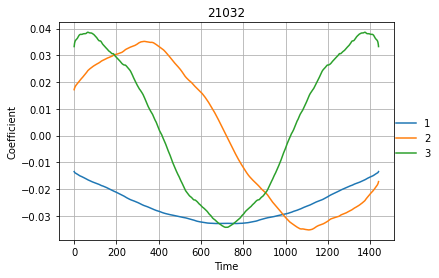

In [13]:
rdr = pd.read_csv("paxraw.csv.gz", error_bad_lines=False, chunksize=24*60*7)

# Number of autocorrelation lags to compute
nlags = 60*24

pdf = PdfPages("ssa_components.pdf")

results = []

def process(df, tau):
    a = acf(df.PAXINTEN, nlags=nlags, fft=True)

    if np.isnan(a).any():
        eiv = np.nan*np.ones(len(a))
    else:
        c = toeplitz(a)
        eiv, eig = np.linalg.eigh(c)
        ii = np.argsort(-eiv)
        eiv = eiv[ii]
        eig = eig[:, ii]

    y = df.PAXINTEN.values
    y = y - y.mean()

    # Get the component corresponding to each
    # singular value.
    xm = hankel(y)[:, 0:nlags+1]
    s = np.sqrt(eiv)
    u = np.dot(xm, eig) / s

    if not tau:
        plt.clf()
        plt.grid(True)
        plt.plot(y)
        plt.xlabel("Time")
        plt.ylabel("Intensity")
        plt.title(df.SEQN.iloc[0])
        pdf.savefig()

    # Plot the components
    plt.clf()
    plt.grid(True)
    for j in 0, 1, 2:
        plt.plot(u[:, j], label=str(j+1))
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

    plt.title(df.SEQN.iloc[0])
    plt.xlabel("Time")
    plt.ylabel("Loading")
    pdf.savefig()

    # Plot the coefficients
    plt.clf()
    plt.grid(True)
    for j in 0, 1, 2:
        plt.plot(eig[:, j], label=str(j+1))
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

    plt.title(df.SEQN.iloc[0])
    plt.xlabel("Time")
    plt.ylabel("Coefficient")
    pdf.savefig()

    eiv = np.concatenate(([df.SEQN.iloc[0]], eiv))
    results.append(eiv)


chunks = []
nsubject = 0
while True:

    try:
        df1 = rdr.get_chunk()
    except StopIteration:
        break

    for idx, v in df1.groupby("SEQN"):
        chunks.append((idx, v))

    ids = [x[0] for x in chunks]

    if len(set(ids)) > 1:
        # z contains complete data for one subject and is
        # ready to process
        z = [x[1] for x in chunks if x[0] == ids[0]]
        chunks = [x for x in chunks if x[0] != ids[0]]
    else:
        continue

    z = pd.concat(z, axis=0)

    for tau in False, True:
        process(z, tau)

    nsubject += 1
    if nsubject % 10 == 0:
        print(nsubject)

    if nsubject > 20:
        break

pdf.close()


### ssa_spectrum

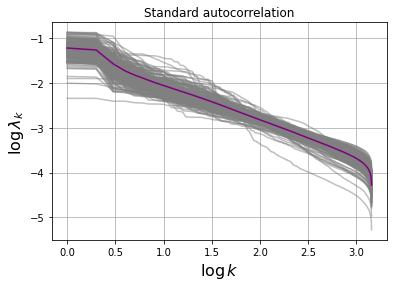

In [44]:
pdf = PdfPages("ssa_spectrum.pdf")


# eiv = pd.read_csv("ssa_eig.csv.gz")
# eiv = eiv.set_index("SEQN")

# Normalize
eivn = eiv.div(eiv.sum(1), axis=0)

plt.clf()
plt.grid(True)
lk = np.log10(1 + np.arange(eivn.shape[1]))
for i in range(200):
    plt.plot(lk, np.log10(eivn.iloc[i, :]), color='grey', alpha=0.5)
y = eivn.mean(0)
plt.plot(lk, np.log10(y), color='purple')
plt.xlabel(r"$\log\, k$", size=16)
plt.ylabel(r"$\log\, \lambda_k$", size=16)
plt.title("Standard autocorrelation")

pdf.savefig()

pdf.close()

In [42]:
eiv

,eig000,eig001,eig002,eig003,eig004,eig005,eig006,eig007,eig008,eig009,...,eig1431,eig1432,eig1433,eig1434,eig1435,eig1436,eig1437,eig1438,eig1439,eig1440
SEQN,,,,,,,,,,,,,,,,,,,,,
21005,114.729895,92.408951,90.292579,69.997114,44.971617,43.581887,37.869890,33.964149,28.599619,18.978089,...,0.062450,0.062410,0.060592,0.060539,0.056237,0.056163,0.053212,0.053089,0.050247,0.050161
21006,67.506892,56.944099,23.354018,21.979410,18.303996,17.229822,15.464703,13.662546,11.683004,10.609116,...,0.121468,0.120957,0.115364,0.115229,0.097857,0.097805,0.095599,0.094754,0.087023,0.086788
21007,83.773680,82.973730,14.823418,13.316360,13.260895,11.803465,9.832855,9.311408,8.917313,8.886471,...,0.123439,0.122722,0.122529,0.122233,0.122142,0.108083,0.108003,0.093512,0.084117,0.070282
21008,102.886024,92.835863,58.912439,53.838432,47.116363,33.290792,25.880534,15.650439,12.901642,12.898797,...,0.044550,0.044486,0.044154,0.044100,0.039997,0.039928,0.038983,0.038750,0.026484,0.026414
21009,138.831286,130.614877,30.016686,23.535006,20.425664,19.635776,16.203506,16.134749,13.536060,11.283218,...,0.101107,0.101091,0.100051,0.099907,0.096627,0.096419,0.095777,0.095735,0.091668,0.091558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31099,59.576984,58.982829,14.983949,14.927960,13.022102,12.697547,9.722595,9.717095,8.717935,8.612602,...,0.121520,0.121392,0.116192,0.116111,0.108007,0.107758,0.104153,0.104080,0.101708,0.101679
31101,129.603297,87.593070,87.480974,29.961241,28.467387,28.362325,9.602839,8.549193,7.473010,5.775439,...,0.083013,0.082999,0.081159,0.081082,0.060485,0.060282,0.043504,0.043395,0.040624,0.040607
31107,116.759110,103.746704,41.460064,39.478784,21.164984,21.147168,20.947226,17.205014,17.131560,15.514323,...,0.064396,0.064361,0.062456,0.062261,0.061867,0.061631,0.056803,0.056778,0.054320,0.054277


### Exculdue "lazy" subjects

In [38]:
# Identify people with abnormal activity intensity
df = pd.read_csv("paxraw.csv.gz")
df.loc[df.PAXINTEN == 0, 'is_zero'] = 0
df.loc[df.PAXINTEN > 0, 'is_zero'] = 1

# Add column to identy intensity = 0 or not
dx = df.groupby(["SEQN", "is_zero"])['is_zero'].count()
dx = dx.groupby('SEQN').apply(lambda x: x / float(x.sum()))
# plt.hist(dx.xs(0.0, level=1).values)
print("Intensity = 0\n", dx.xs(0.0, level=1).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
print("Intensity > 0\n",dx.xs(1.0, level=1).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

# Exclude people that have over 90% of zero intensity
dd = dx.xs(0.0, level=1, drop_level=True)
idx = dd[dd <= 0.9].index.values
eiv = pd.read_csv("ssa_eig.csv.gz")
print(eiv.shape)
eiv = eiv[eiv.SEQN.isin(idx)]
print(eiv.shape)

# merge new data
eiv.dropna(axis=0, inplace=True)
eiv = eiv.set_index('SEQN')


demo = pd.read_sas("DEMO_C.XPT")
demo = demo[["SEQN", "RIDAGEYR", "RIAGENDR"]]

# Blood pressure data
# bp = pd.read_sas("BPX_C.XPT")
# bp = bp[["SEQN", "BPXSY1", "BPXSY2"]]

# bmi data
bmi = pd.read_sas("BMX_C.XPT")
bmi = bmi[["SEQN", "BMXBMI"]]


# df = pd.merge(demo, eiv, left_on="SEQN", right_on="SEQN")
df = pd.merge(demo, eiv,  left_on="SEQN",right_on="SEQN")
df = pd.merge(df, bmi, left_on="SEQN", right_on="SEQN")

df.to_csv("new_merged.csv.gz", index=None)

Intensity = 0
 count    7168.000000
mean        0.663901
std         0.136897
min         0.032540
5%          0.473115
25%         0.564335
50%         0.643849
75%         0.746949
95%         0.931865
max         1.000000
Name: is_zero, dtype: float64
Intensity > 0
 count    7172.000000
mean        0.337027
std         0.138413
min         0.000099
5%          0.069444
25%         0.254043
50%         0.356597
75%         0.436136
95%         0.527922
max         1.000000
Name: is_zero, dtype: float64
(7167, 1442)
(6648, 1442)


In [40]:
eiv

,eig000,eig001,eig002,eig003,eig004,eig005,eig006,eig007,eig008,eig009,...,eig1431,eig1432,eig1433,eig1434,eig1435,eig1436,eig1437,eig1438,eig1439,eig1440
SEQN,,,,,,,,,,,,,,,,,,,,,
21005,114.729895,92.408951,90.292579,69.997114,44.971617,43.581887,37.869890,33.964149,28.599619,18.978089,...,0.062450,0.062410,0.060592,0.060539,0.056237,0.056163,0.053212,0.053089,0.050247,0.050161
21006,67.506892,56.944099,23.354018,21.979410,18.303996,17.229822,15.464703,13.662546,11.683004,10.609116,...,0.121468,0.120957,0.115364,0.115229,0.097857,0.097805,0.095599,0.094754,0.087023,0.086788
21007,83.773680,82.973730,14.823418,13.316360,13.260895,11.803465,9.832855,9.311408,8.917313,8.886471,...,0.123439,0.122722,0.122529,0.122233,0.122142,0.108083,0.108003,0.093512,0.084117,0.070282
21008,102.886024,92.835863,58.912439,53.838432,47.116363,33.290792,25.880534,15.650439,12.901642,12.898797,...,0.044550,0.044486,0.044154,0.044100,0.039997,0.039928,0.038983,0.038750,0.026484,0.026414
21009,138.831286,130.614877,30.016686,23.535006,20.425664,19.635776,16.203506,16.134749,13.536060,11.283218,...,0.101107,0.101091,0.100051,0.099907,0.096627,0.096419,0.095777,0.095735,0.091668,0.091558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31099,59.576984,58.982829,14.983949,14.927960,13.022102,12.697547,9.722595,9.717095,8.717935,8.612602,...,0.121520,0.121392,0.116192,0.116111,0.108007,0.107758,0.104153,0.104080,0.101708,0.101679
31101,129.603297,87.593070,87.480974,29.961241,28.467387,28.362325,9.602839,8.549193,7.473010,5.775439,...,0.083013,0.082999,0.081159,0.081082,0.060485,0.060282,0.043504,0.043395,0.040624,0.040607
31107,116.759110,103.746704,41.460064,39.478784,21.164984,21.147168,20.947226,17.205014,17.131560,15.514323,...,0.064396,0.064361,0.062456,0.062261,0.061867,0.061631,0.056803,0.056778,0.054320,0.054277


### PCA

In [24]:
from sklearn.decomposition import PCA
# The first 3 components account for most of the variances
pca = PCA(n_components=2)
pca.fit(eiv)

print("Explained Variance: ", np.round(pca.explained_variance_, 3))
print("Explained Variance Ratio: ", np.round(pca.explained_variance_ratio_, 3))

# X = pca.fit_transform(eiv)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=eiv.columns)
loadings

Explained Variance:  [4925.37   851.179]
Explained Variance Ratio:  [0.733 0.127]


,PC1,PC2
eig000,0.869711,0.332750
eig001,0.441080,-0.344328
eig002,0.184640,-0.469966
eig003,0.081643,-0.351602
eig004,0.048471,-0.293256
...,...,...
eig1436,-0.000176,0.000707
eig1437,-0.000167,0.000666
eig1438,-0.000166,0.000662
eig1439,-0.000154,0.000598


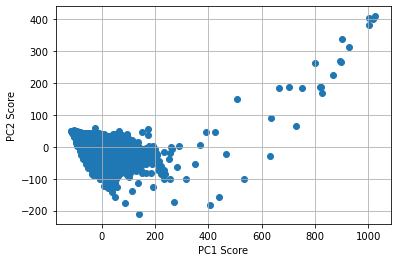

In [25]:
scores = pd.DataFrame(pca.transform(eiv), columns=['PC1', 'PC2'], index=eiv.index)
eigenvalues = pca.singular_values_

plt.grid(True)
plt.scatter(x = scores.PC1, y = scores.PC2)
plt.xlabel("PC1 Score")
_ = plt.ylabel("PC2 Score")

Loadings:  [0.86971136 0.44108046 0.18464019 0.08164322 0.04847091 0.02807706
 0.01790737 0.00968383 0.0051437  0.00106775]


(1441,)

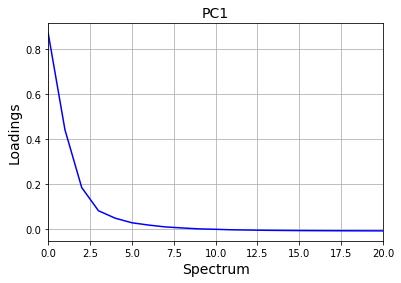

In [28]:
# Plot loadings
plt.clf()
plt.grid(True)
# pc1 = np.sort(loadings.PC1.values)[::-1]
pc1 = loadings.PC1.values
print("Loadings: ", pc1[:10])
x = np.linspace(0, 1441, num=1441)
plt.plot(x, log(pc1, color='blue', label="PC1")
plt.xlabel("Spectrum", size=14)
plt.ylabel("Loadings", size=14)
plt.xlim((0, 20))
_ = plt.title("PC1", size=14)
pc1.shape

In [68]:
pc1s = scores.PC1
pc1s_new = pd.merge(demo, pc1s,  left_on="SEQN",right_on="SEQN")

pcs_new = pd.merge(pc1s_new, scores.PC2,  left_on="SEQN",right_on="SEQN")
pcs_new

,SEQN,RIDAGEYR,RIAGENDR,PC1,PC2
0,21005.0,19.0,1.0,45.621926,-61.378076
1,21006.0,16.0,2.0,-30.790453,15.506450
2,21007.0,14.0,2.0,-7.653125,25.979545
3,21008.0,17.0,1.0,27.140760,-30.924282
4,21009.0,55.0,1.0,65.884518,8.664335
...,...,...,...,...,...
6639,31099.0,17.0,2.0,-39.397769,25.797856
6640,31101.0,46.0,2.0,50.758104,-4.979157
6641,31107.0,12.0,1.0,37.443887,-11.224242
6642,31108.0,72.0,2.0,-31.192738,36.207267


In [60]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


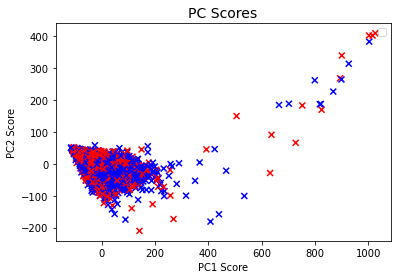

In [77]:
# plt.grid(True)
# plt.scatter(x = scores.PC1, y = scores.PC2)
# plt.xlabel("PC1 Score")
# _ = plt.ylabel("PC2 Score")







fig = plt.figure()
ax = plt.gca()
# plt.xlim(0, 1)
# plt.ylim(0, 1)
color_map = {1: 'b', 2: 'r'}
ax.scatter(pcs_new["PC1"], pcs_new["PC2"], c=pcs_new["RIAGENDR"].apply(lambda x: color_map[x]), marker="x")
plt.xlabel("PC1 Score")
ax.legend(handles, labels, loc="upper right", title="Gender")
_ = plt.ylabel("PC2 Score")
_ = plt.title("PC Scores", size=14)
plt.show()




In [ ]:
from matplotlib.colors import ListedColormap



fig = plt.figure()
ax = plt.gca()

color_map = {1: 'b', 2: 'r'}
ax.scatter(pcs_new["PC1"], pcs_new["PC2"], c=pcs_new["RIAGENDR"].apply(lambda x: color_map[x]), marker="x")
plt.xlabel("PC1 Score")
ax.legend(handles, labels, loc="upper right", title="Gender")
_ = plt.ylabel("PC2 Score")
_ = plt.title("PC Scores", size=14)
plt.show()




classes = ['A', 'B', 'C']
values = [0, 0, 1, 2, 2, 2]
colours = ListedColormap(['r','b','g'])
scatter = plt.scatter(x, y,c=values, cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

In [49]:
loadings.PC1.values

array([ 8.69711356e-01,  4.41080461e-01,  1.84640185e-01, ...,
       -1.66230857e-04, -1.53930528e-04, -1.52591613e-04])

Loadings:  [ 0.3327 -0.3443 -0.47   -0.3516 -0.2933 -0.249  -0.2163 -0.1897 -0.1694
 -0.1535 -0.1393 -0.1268 -0.1164 -0.1069 -0.0983 -0.0911 -0.0842 -0.0782
 -0.0727 -0.0674]


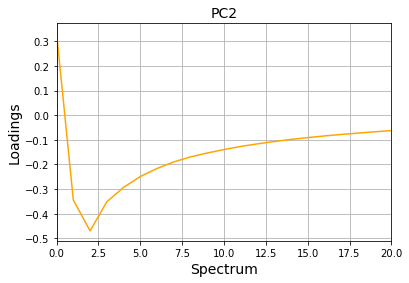

In [45]:
plt.clf()
plt.grid(True)
# pc2 = np.sort(loadings.PC2.values)[::-1]
pc2 = loadings.PC2.values
print("Loadings: ", np.round(pc2[:20], 4))
x = np.linspace(0, 1441, num=1441)
plt.plot(x, pc2, color='orange', label="PC2")
plt.xlim((0, 20))
plt.xlabel("Spectrum", size=14)
plt.ylabel("Loadings", size=14)
_ = plt.title("PC2", size=14)

In [52]:
print(scores.PC1)

SEQN
21005    45.621926
21006   -30.790453
21007    -7.653125
21008    27.140760
21009    65.884518
           ...    
31099   -39.397769
31101    50.758104
31107    37.443887
31108   -31.192738
31110   -39.424548
Name: PC1, Length: 6644, dtype: float64
